In [1]:
# Import Packages
import os
import pandas as pd
import numpy as np

# Change Working Directory
os.chdir(r'E:/DHICA/23016 - Aeródromo/Informe/Lluvia/77001_Batan')

# Read the Data
data = pd.read_csv('77001_Batan.csv')

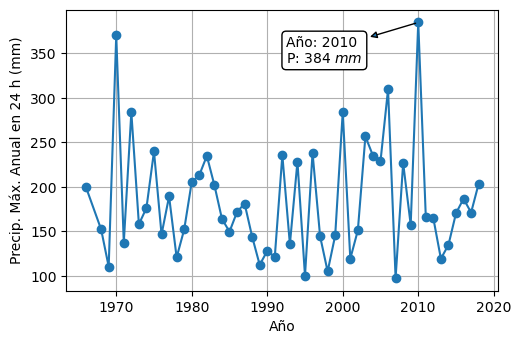

In [7]:
# Plot the Data
import matplotlib.pyplot as plt

# Maximum Values
id_max = data['PMax_24'].idxmax()
x_max = data['Year'].loc[id_max]
y_max = data['PMax_24'].loc[id_max]
label = 'Año: %d \nP: %d $mm$' % (x_max, y_max)

# Conversion
cm = 1/2.54

# Plot
fig, ax = plt.subplots(figsize=(13.5*cm, 9*cm), facecolor='white', tight_layout=True)

# Plot 1
ax.plot(data['Year'], data['PMax_24'], marker='o', color='tab:blue')
ax.set_xlabel('Año')
ax.set_ylabel('Precip. Máx. Anual en 24 h (mm)')
ax.annotate(text=label, xy=(x_max, y_max), xytext=(x_max-17.5, y_max-45), arrowprops={'arrowstyle':'<|-'},
             bbox={'boxstyle':'round', 'facecolor':'white', 'edgecolor':'black'}, annotation_clip=True)
# ax.set_xticks(np.arange(2000, 2020+1, 5))
ax.grid()

# Show Plots
plt.savefig('rainfall.png', dpi=300)
plt.show()

In [12]:
# Get Data
values = data['PMax_24'].values

# Fit GEV
from scipy.stats import genextreme

c_fit, loc_fit, scale_fit = genextreme.fit(values, method="mle")

In [13]:
print(f"n = {len(values)}\nc = {c_fit}\nloc = {loc_fit}\nscale = {scale_fit}")

# Write Parameters
f = open('gev_parameters.txt','w')
f.write('n = ' + str(len(values)))
f.write('\nc = ' + str(c_fit))
f.write('\nloc = ' + str(loc_fit))
f.write('\nscale = ' + str(scale_fit))
f.close()

n = 52
c = -0.1193509883910367
loc = 153.06828029400796
scale = 43.87376425980942


In [14]:
# KS-Test
from scipy import stats
from scipy.stats import ksone
from scipy.stats import anderson

alpha = 0.05
ks, p = stats.ks_1samp(values, genextreme.cdf, args=(c_fit, loc_fit, scale_fit))
ks_crit = ksone.ppf(1-alpha/2, len(values))
print('KS: %f \nKS_Crit: %f' % (ks, ks_crit))
if ks < ks_crit:
    print('Good Fit!')
else:
    print('BAD Fit')

# Anderson-Darling Test
statistic, critical_values, significance = anderson(values, dist='gumbel')
print('\nAnderson statistic: %f' % (statistic))
print('Critical Anderson-Darling:', critical_values)
print('Anderson-Darling Significance Level:', significance)
if  statistic > critical_values[2]:
    print('Good Fit!')
else:
    print('BAD Fit')

KS: 0.074817 
KS_Crit: 0.184824
Good Fit!

Anderson statistic: 3.219732
Critical Anderson-Darling: [0.461 0.62  0.737 0.853 1.01 ]
Anderson-Darling Significance Level: [25.  10.   5.   2.5  1. ]
Good Fit!


In [15]:
# Estimate Design Rainfall Values
return_periods = [2, 5, 10, 25, 50, 100, 500]
pp_design = []

for i in return_periods:
    pp_design.append(np.round(genextreme.ppf(1 - 1/i, c=c_fit, loc=loc_fit, scale=scale_fit),2))
    
print(pp_design)

[169.51, 225.13, 266.33, 323.95, 371.1, 422.0, 557.17]


In [16]:
# Bootstraped Confidence Intervals
np.random.seed(0)

n_size = len(values)
alpha = 0.95
ks_crit = ksone.ppf(1-alpha/2, n_size)

x = np.linspace(np.min(values), np.max(values), 100)
return_periods = [2, 5, 10, 25, 50, 100, 500]
column_names = []

for i in return_periods:
    column = 'PP' + str(i)
    column_names.append(column)
    
PP = pd.DataFrame(columns=column_names)
CDF_DF = pd.DataFrame(columns=x)
PDF_DF = pd.DataFrame(columns=x)

iter = 300
i = 0
while i < iter:
    # Create Parametric Bootsrap Sample
    sample = []
    for j in range(n_size):
        sample.append(np.round(genextreme.ppf(np.random.random(1)[0], c=c_fit, loc=loc_fit, scale=scale_fit),2))
    
    # Fit Sample
    c_samp, loc_samp, scale_samp = genextreme.fit(sample)
    
    # GoF Test
    ks, p = stats.ks_1samp(sample, genextreme.cdf, args=(c_samp, loc_samp, scale_samp))
    if ks < ks_crit:
        for j in return_periods:
            PP.loc[i, ['PP' + str(j)]] = np.round(genextreme.ppf(1 - 1/j, c=c_samp, loc=loc_samp, scale=scale_samp),2)
        for j in x:
            CDF_DF.loc[i, [j]] = genextreme.cdf(j, c=c_samp, loc=loc_samp, scale=scale_samp)
            PDF_DF.loc[i, [j]] = genextreme.pdf(j, c=c_samp, loc=loc_samp, scale=scale_samp)
        i += 1
        if i % 50 == 0:
            print('Fittings: ', str(i))

Fittings:  50
Fittings:  100
Fittings:  150
Fittings:  200
Fittings:  250
Fittings:  300


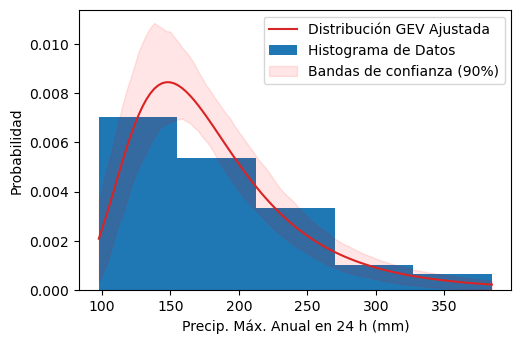

In [17]:
# 90% Confidence Bands PDF
lower_bound, upper_bound = [], []

for i in x:
    lower_bound.append(np.round(PDF_DF[i].quantile(0.05),5))
    upper_bound.append(np.round(PDF_DF[i].quantile(0.95),5))
    
# Plot
fig, ax = plt.subplots(figsize=(13.5*cm, 9*cm), facecolor='white', tight_layout=True)

pdf_fit = genextreme.pdf(x, c=c_fit, loc=loc_fit, scale=scale_fit)

# Plot 1
n_bins = len(np.histogram_bin_edges(values, bins='scott')) - 1
ax.hist(values, bins=n_bins, density=True, stacked=True, label='Histograma de Datos', zorder=0)
ax.plot(x, pdf_fit, marker='', color='tab:red', label='Distribución GEV Ajustada', zorder=5)
ax.fill_between(x, lower_bound, upper_bound, color='r', alpha=.1, label='Bandas de confianza (90%)', zorder=10)
ax.set_xlabel('Precip. Máx. Anual en 24 h (mm)')
ax.set_ylabel('Probabilidad')
handles, labels = ax.get_legend_handles_labels()
order = [1,0,2]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
ax.legend(handles, labels)

# Show Plot
plt.savefig('pdf_90.png', dpi=300)
plt.show()

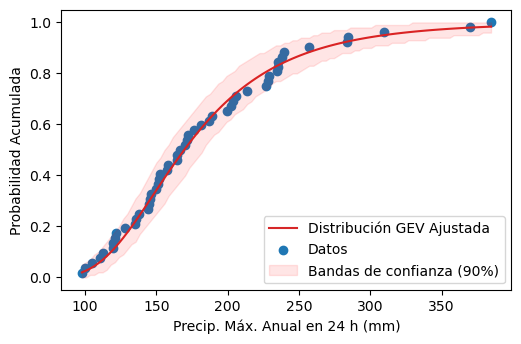

In [18]:
# 90% Confidence Bands CDF
from scipy.stats.mstats import plotting_positions

lower_bound, upper_bound = [], []

for i in x:
    lower_bound.append(np.round(CDF_DF[i].quantile(0.05),2))
    upper_bound.append(np.round(CDF_DF[i].quantile(0.95),2))
    
# Plot
fig, ax = plt.subplots(figsize=(13.5*cm, 9*cm), facecolor='white', tight_layout=True)

cdf_values = plotting_positions(values, alpha=0, beta=1)
cdf_fit = genextreme.cdf(x, c=c_fit, loc=loc_fit, scale=scale_fit)

# Plot 2
ax.scatter(values, cdf_values, marker='o', label='Datos', zorder=0)
ax.plot(x, cdf_fit, marker='', color='tab:red', label='Distribución GEV Ajustada', zorder=5)
ax.fill_between(x, lower_bound, upper_bound, color='r', alpha=.1, label='Bandas de confianza (90%)', zorder=10)
#ax.set_xticks(np.arange(0, 500, step=10))
#ax.set_xlim(0,101.2)
#ax.set_ylim(150,550)
ax.set_xlabel('Precip. Máx. Anual en 24 h (mm)')
ax.set_ylabel('Probabilidad Acumulada')
handles, labels = ax.get_legend_handles_labels()
order = [1,0,2]
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]
ax.legend(handles, labels)

# Show Plot
plt.savefig('cdf_90.png', dpi=300)
plt.show()

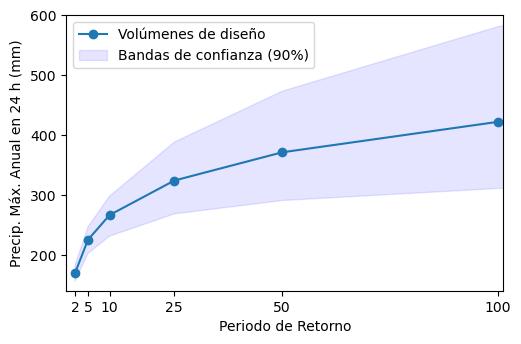

In [22]:
# 90% Confidence Bands
lower_bound, upper_bound = [], []

for i in column_names:
    lower_bound.append(np.round(PP[i].quantile(0.05),2))
    upper_bound.append(np.round(PP[i].quantile(0.95),2))

# Plot
fig, ax = plt.subplots(figsize=(13.5*cm, 9*cm), facecolor='white', tight_layout=True)

# Plot 1
ax.plot(return_periods, pp_design, marker='o', label='Volúmenes de diseño')
ax.fill_between(return_periods, lower_bound, upper_bound, color='b', alpha=.1, label='Bandas de confianza (90%)')
ax.set_xticks([2, 5, 10, 25, 50, 100])
ax.set_xlim(0,101.2)
ax.set_ylim(140,600)
ax.set_xlabel('Periodo de Retorno')
ax.set_ylabel('Precip. Máx. Anual en 24 h (mm)')
ax.legend(loc=2)

# Show Plot
plt.savefig('confidence.png', dpi=300)
plt.show()

In [25]:
#Save Results
df = pd.DataFrame(list(zip(return_periods, lower_bound, pp_design, upper_bound)),
               columns =['Return Period', 'Lower Bound', 'PP', 'Upper Bound'])
df.to_csv('results.txt', index=False, sep="\t")